### BBC Full Text Document Classification Project

Contents

1.Goal of The Project

2.General View of Data

3.Preprocessing of Data

4.Exploring the Data

5.Building Models

6.Results

#### 1.Goal of The Project

In this project, we will try to establish logistics regression models are used to predict the topics of the relevant texts.

#### 2.General View of Data

### Importing used libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import PorterStemmer
from sklearn import model_selection,linear_model
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection,linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\90552\\Desktop\\kübra\\DATAJARLABS\\sınıflandırma_projesi\\bbc_text'

In [3]:
# Creating a Df with 4 columns: Category, FileName, Title, Text
all_data = []
titles = []
for direc_name,category,file_name in os.walk(path):
    for f in file_name:
        # Absolute path
        file = os.path.join(direc_name,f)
        open_file = open(file, "r")
        # text_data
        text_data = open_file.read().split("\n")
        
        titles.append(text_data[0])
        all_data.append((os.path.basename(direc_name),f,text_data[0],pd.Series(text_data[1:]).str.cat(sep=" ")))
        open_file.close()
text_df = pd.DataFrame(data=all_data, columns=["category","file_name","titles","text"])
text_df.head()

,category,file_name,titles,text
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [4]:
df = text_df.copy() 

In [5]:
type(df["text"])

pandas.core.series.Series

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   2225 non-null   object
 1   file_name  2225 non-null   object
 2   titles     2225 non-null   object
 3   text       2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [7]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [8]:
df.describe()

,category,file_name,titles,text
count,2225,2225,2225,2225
unique,5,511,2096,2092
top,sport,210.txt,Warning over tsunami aid website,"A US airline attendant suspended over ""inappr..."
freq,511,5,2,2


#### 3.Preprocessing of Data

In [9]:
#converting special characters

In [10]:
df["titles"] = df["titles"].replace({"$":" currency", "£":" currency" , "%": " percent" , "US":"united state", "BA":"British Airways",
                     "FAO":"Food and Agriculture Organisation" , "GDP":"Gross Domestic Product",
                     "UK":"united kingdom" , "ISM":"The Institute for Supply Management" ,
                     "PPI":"The Pensions Policy Institute" , "PFI":"Private Finance Initiative" },regex=True)

In [11]:
df["text"] = df["text"].replace({"$":"currency", "£":" currency " , "%": " percent" , "US":"united state", "BA":"British Airways",
                     "FAO":"Food and Agriculture Organisation" , "GDP":"Gross Domestic Product",
                     "UK":"united kingdom" , "ISM":"The Institute for Supply Management" ,
                     "PPI":"The Pensions Policy Institute" , "PFI":"Private Finance Initiative" },regex=True)

In [12]:
#Since it doesn't convert contiguous numbers, I did the operation again.
df["text"] = df["text"].str.replace("$","currency ")

In [13]:
#lower conversation

In [14]:
df["titles"] = df["titles"].str.lower()

In [15]:
df["text"] = df["text"].str.lower()

In [16]:
#remove punctuation marks

In [17]:
df["titles"] = df["titles"].str.replace("[^\w\s]","")

In [18]:
df["text"] = df["text"].str.replace("[^\w\s]","")

In [19]:
#convert of numbers

In [20]:
df.text = df.text.str.split()

In [21]:
df.titles = df.titles.str.split()

In [22]:
def convert_number(row):
    new_row = []
    
    for word in row:
        
        try:
            
            word = float(word)
            word = "number_"
        
        except:
            
            pass
        new_row.append(word)
        
    return new_row

In [23]:
for i,row in enumerate(df.text):
    
    df.text[i] = convert_number(row)
df.head()

,category,file_name,titles,text
0,business,001.txt,"[ad, sales, boost, time, warner, profit, curre...","[quarterly, profits, at, united, state, media,..."
1,business,002.txt,"[dollar, gains, on, greenspan, speech, currency]","[the, dollar, has, hit, its, highest, level, a..."
2,business,003.txt,"[yukos, unit, buyer, faces, loan, claim, curre...","[the, owners, of, embattled, russian, oil, gia..."
3,business,004.txt,"[high, fuel, prices, hit, british, airwayss, p...","[british, airways, has, blamed, high, fuel, pr..."
4,business,005.txt,"[pernod, takeover, talk, lifts, domecq, currency]","[shares, in, united, kingdom, drinks, and, foo..."


In [24]:
for i,row in enumerate(df.titles):
    
    df.titles[i] = convert_number(row)
df.head()

,category,file_name,titles,text
0,business,001.txt,"[ad, sales, boost, time, warner, profit, curre...","[quarterly, profits, at, united, state, media,..."
1,business,002.txt,"[dollar, gains, on, greenspan, speech, currency]","[the, dollar, has, hit, its, highest, level, a..."
2,business,003.txt,"[yukos, unit, buyer, faces, loan, claim, curre...","[the, owners, of, embattled, russian, oil, gia..."
3,business,004.txt,"[high, fuel, prices, hit, british, airwayss, p...","[british, airways, has, blamed, high, fuel, pr..."
4,business,005.txt,"[pernod, takeover, talk, lifts, domecq, currency]","[shares, in, united, kingdom, drinks, and, foo..."


In [25]:
# Deleting non-convertible numbers

In [26]:
df.titles = df.titles.apply(lambda x: " ".join( word for word in x))
df.text = df.text.apply(lambda x: " ".join( word for word in x))

In [27]:
df["titles"] = df["titles"].str.replace("\d","")
df["text"] = df["text"].str.replace("\d","")

In [28]:
#remove of stopwords

In [29]:
import nltk

In [30]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90552\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
#list of stopwords
sw = stopwords.words("english")

In [32]:
df["titles"] = df["titles"].apply(lambda x: " ".join(word for word in x.split() if word not in sw))
df["text"] = df["text"].apply(lambda x: " ".join(word for word in x.split() if word not in sw))

In [33]:
#PorterStemmer

In [34]:
porter = PorterStemmer()

In [35]:
df["titles"] = df["titles"].apply(lambda x: " ".join(porter.stem(word) for word in x.split()))

In [36]:
df["text"] = df["text"].apply(lambda x: " ".join(porter.stem(word) for word in x.split() ))

In [37]:
#conversion of verbs into infinitive verbs

In [38]:
infinitive_words = ["abide","arise","awake","bear","beat","become","beget","begin","bleed","blow","break","bring","broadcast","build","burn","buy","can","catch","chide","choose","cling","clothe","come","creep","deal","dig","dive","do","draw","dream","drink","drive","dwell","eat","fall","feed","feel","fight","find","flee","fling","fly","forbid","foresee","forget","forgive","forsake","freeze","get","give","go","grind","grow","hang","have","hear","hide","hold","keep","kneel","know","lay","lead","lean","leap","learn","leave","lend","lie","light","lose","make","mean","meet","mow","overcome","partake","pay","plead","prove","relay","rend","ring","rise","run","say","see","seek","sell","send","shake","shine","shoe","shoot","show","sing","sink","sit","slay","sleep","slide","smell","sow","speak","speed","spell","spend","spill","spin","spit","spoil","spring","stand","steal","stick","sting","stink","strew","strike","strive","swear","sweep","swell","swim","swing","take","teach","tear","tell","think","thrive","throw","undergo","understand","wake","wear","weep","wet","win","wind","withdraw","write","wring"]

In [39]:
past_words = ["abode","arose","awoke","bore","beat","became","begat","began","bled","blew","broke","brought","broadcast","built","burnt","bought","could","caught", "chid","chose","clung","clad","came","crept","dealt","dug","dived","did","drew","dreamt","drank","drove","dwelt","ate","fell","fed","felt","fought","found","fled","flung","flew","forbade","foresaw","forgot","forgave","forsook","froze","got","gave","went","ground","grew","hung","had","heard","hid","held","kept","knelt","knew","laid","led","leant","leapt","learnt","left","lent","lay","lit","lost","made","meant","met","mowed","overcame","partook","paid","pled","proved","relaid","rent","rang","rose","ran","said","saw","sought","sold","sent","shook","shone","shod","shot","showed","sang","sank","sat","slew","slept","slid","smelt","sowed","spoke","sped","spelt","spent","spilt","spun","spat","spoilt","sprang","stood","stole","stuck","stung","stank","strewed","struck","strove","swore","swept","swelled","swam","swung","took","taught","tore","told","thought","thrive","threw","underwent","understood","woke","wore","wept","weted","won","wound","withdrew","wrote","wrung"]

In [40]:
part_words = ["abode","arisen","awoken","born","beaten","become","begot","begun","bled","blown","broken","brought","broadcast","built","burnt","bought","could","caught","chidden","chosen","clung","clad","come","crept","dealt","dug","dove","done","drawn","dreamt","drunk","driven","dwelt","eaten","fallen","fed","felt","fought","found","fled","flung","flown","forbidden","foreseen","forgotten","forgiven","forsaken","frozen","gotten","given","gone","ground","grown","hung","had","heard","hidden","held","kept","knelt","known","laid","led","leant","leapt","learnt","left","lent","lain","lit","lost","made","meant","met","mown","overcome","partaken","paid","pled","proven","relaid","rent","rung","risen","run","said","seen","sought","sold","sent","shaken","shone","shod","shot","shown","sung","sunk","sat","slain","slept","slid","smelt","sown","spoken","sped","spelt","spent","spilt","spun","spit","spoilt","sprung","stood","stolen","stuck","stung","stunk","strewn","stricken","striven","sworn","swept","swollen","swum","swung","taken","taught","torn","told","thought","thriven","thrown","undergone","understood","woken","worn","wept","weted","won","wound","withdrawn","written","wrung"]

In [41]:
df["text"] = df["text"].replace(past_words,infinitive_words,regex=True)
df["text"] = df["text"].replace(part_words,infinitive_words,regex=True)
df["titles"] = df["titles"].replace(past_words,infinitive_words,regex=True)
df["titles"] = df["titles"].replace(part_words,infinitive_words,regex=True)

In [42]:
# remove of rare words

In [43]:
title_value = pd.Series(df.titles.str.split().sum()).value_counts()

In [44]:
len(title_value[title_value==1]) 

1517

In [45]:
text_value = pd.Series(df["text"].str.split().sum()).value_counts()

In [46]:
len(text_value)

21286

In [47]:
len(text_value[text_value==1])

7667

In [48]:
text_rare_list = text_value[-7667:]

In [49]:
df["text"] = df["text"].apply(lambda x: " ".join(word for word in x.split() if word not in text_rare_list ))

In [50]:
# listing and deleting words with length less than 3
list1 = []
for word in set(df["text"].str.split().sum()):
    if len(word)<3:
        list1.append(word)
print(list1)

['n', 'th', 'gu', 'da', 'hl', 'rj', 'ok', 'ms', 'tp', 'sv', 'vw', 'vc', 'db', 'hq', 'gw', 'pm', 'fm', 'sp', 'pb', 'du', 'un', 'g', 'ed', 'im', 'bu', 'le', 'ds', 'pe', 'en', 'ni', 'hd', 'sn', 'ag', 'tb', 'hp', 'p', 'ar', 'qv', 'uv', 'gt', 'pr', 'b', 'lw', 'od', 'ru', 'ft', 'vs', 'ra', 'ap', 'de', 'k', 'sg', 'jr', 'lr', 'ub', 'ce', 'gb', 'lg', 'on', 'rd', 'fn', 'cm', 'ca', 'mm', 'km', 'tv', 'mb', 'et', 'us', 'e', 'ge', 'ai', 'ps', 'co', 'ec', 'qa', 'tu', 'di', 'sr', 'mi', 'mc', 'ya', 'kg', 'if', 'vy', 'nt', 'yh', 'rk', 'ir', 'iv', 'il', 'ea', 'â', 'eu', 'pa', 'pj', 'eq', 'xm', 'og', 'st', 'cb', 'sc', 'dr', 'dj', 'be', 'ae', 'hm', 'vi', 'em', 'az', 'pc', 'we', 'se', 'v', 'ak', 'av', 'el', 'oh', 'go', 'nz', 'li', 'na', 'ie', 'sm', 'jo', 'bn', 'do', 'ja', 'fc', 'w', 'sk', 'r', 'uk', 'pp', 'mw', 'mg', 'mâ', 'ip', 'ma', 'j', 'l', 'lt', 'dc', 'jd', 'vj', 'xp', 'ac', 'c', 'ga', 'he', 'jp', 'nh', 'kk', 'rt', 'jk', 're', 'qc', 'bo', 'sa', 'la', 'bp', 'nu', 'vh', 'bb', 'q', 'cp', 'ye', 'fa', 'ep',

In [51]:
df["text"] = df["text"].apply(lambda x: " ".join(word for word in x.split() if word not in list1 ))

In [52]:
# conversion of numbers expressed as text in text

In [53]:
number_list = ["zero","one","two","three","four","five","six","seven","eight","nine","ten","eleven","sixteen","eighteen",
               "first","second","third","fourth","fifth","sixth","seventh","eighth","ninth","tenth"]

In [54]:
df.titles = df.titles.str.split()

In [55]:
df.text = df.text.str.split()

In [56]:
def convert_number(row):
    new_row = []
    
    for word in row:
        
        if word in number_list:
            word = "number_"
        
        else:
            
            pass
        new_row.append(word)
        
    return new_row

In [57]:
for i,row in enumerate(df.text):
    
    df.text[i] = convert_number(row)
df.head(10)

,category,file_name,titles,text
0,business,001.txt,"[ad, sale, boost, time, warner, profit, currenc]","[quarterli, profit, unit, steat, media, giant,..."
1,business,002.txt,"[dollar, gain, greenspan, speech, currenc]","[dollar, hit, highest, level, euro, almost, nu..."
2,business,003.txt,"[yuko, unit, buyer, face, loan, claim, currenc]","[owner, embattl, russian, oil, giant, yuko, as..."
3,business,004.txt,"[high, fuel, price, hit, british, airwayss, pr...","[british, airway, blame, high, fuel, price, nu..."
4,business,005.txt,"[pernod, takeov, talk, lift, domecq, currenc]","[share, unit, kingdom, drink, food, firm, alli..."
5,business,006.txt,"[japan, narrowli, escap, recess, currenc]","[japan, economi, teeter, brink, technic, reces..."
6,business,007.txt,"[job, growth, still, slow, unit, steat, currenc]","[unit, steat, creat, fewer, job, expect, janua..."
7,business,008.txt,"[india, call, fair, trade, rule, currenc]","[india, attend, meet, number_, lead, industria..."
8,business,009.txt,"[ethiopia, crop, product, number_, percent, cu...","[ethiopia, produc, number_, million, tonn, cro..."
9,business,010.txt,"[court, reject, bn, tobacco, case, currenc]","[unit, steat, govern, claim, accus, countri, b..."


In [58]:
for i,row in enumerate(df.titles):
    
    df.titles[i] = convert_number(row)
df.head(10)

,category,file_name,titles,text
0,business,001.txt,"[ad, sale, boost, time, warner, profit, currenc]","[quarterli, profit, unit, steat, media, giant,..."
1,business,002.txt,"[dollar, gain, greenspan, speech, currenc]","[dollar, hit, highest, level, euro, almost, nu..."
2,business,003.txt,"[yuko, unit, buyer, face, loan, claim, currenc]","[owner, embattl, russian, oil, giant, yuko, as..."
3,business,004.txt,"[high, fuel, price, hit, british, airwayss, pr...","[british, airway, blame, high, fuel, price, nu..."
4,business,005.txt,"[pernod, takeov, talk, lift, domecq, currenc]","[share, unit, kingdom, drink, food, firm, alli..."
5,business,006.txt,"[japan, narrowli, escap, recess, currenc]","[japan, economi, teeter, brink, technic, reces..."
6,business,007.txt,"[job, growth, still, slow, unit, steat, currenc]","[unit, steat, creat, fewer, job, expect, janua..."
7,business,008.txt,"[india, call, fair, trade, rule, currenc]","[india, attend, meet, number_, lead, industria..."
8,business,009.txt,"[ethiopia, crop, product, number_, percent, cu...","[ethiopia, produc, number_, million, tonn, cro..."
9,business,010.txt,"[court, reject, bn, tobacco, case, currenc]","[unit, steat, govern, claim, accus, countri, b..."


In [59]:
#listing unique values

In [60]:
unique_words = set(df["text"].sum())

In [61]:
unique_words = sorted(unique_words)

In [62]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

#### 4.Exploring the Data

In [63]:
#visualization

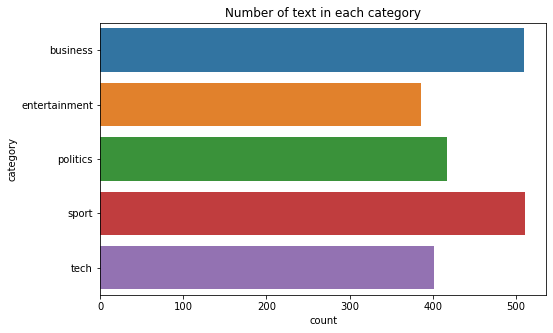

In [64]:
plt.figure(figsize=(8,5))
sns.countplot(y=df.category)
plt.title("Number of text in each category")
plt.show()

In [65]:
#Word Cloud

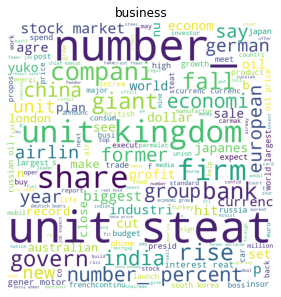

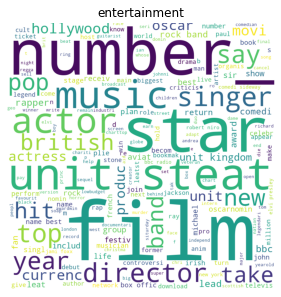

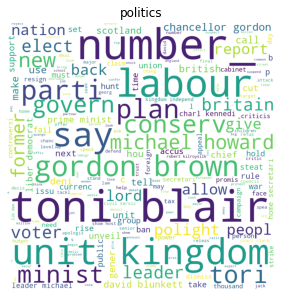

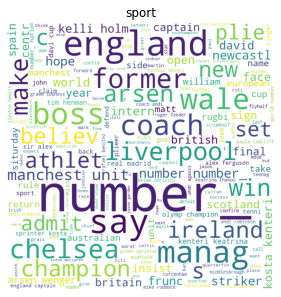

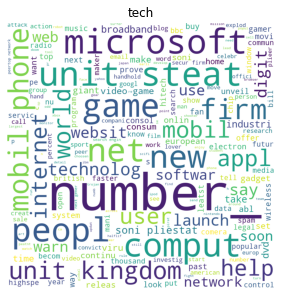

In [66]:
for cat in df.category.unique():
    word_cloud = WordCloud(width = 800, height = 800, background_color ="white",
                   min_font_size = 10, random_state=42)
    word_cloud.generate(df.text[(df.category == cat)].to_string())
    
    plt.imshow(word_cloud)
    plt.tight_layout(pad = 0) 
    plt.title(cat)
    plt.axis("off")
    plt.show()

#### Word Vectors

In [67]:
df1 = df.copy()

In [68]:
#for df.titles:

cat_list = ["business","entertainment","sport","politics","tech"]
word_frequency_titles = []

for cat in cat_list:
    tf = pd.value_counts(df1[df1["category"]==cat]["titles"].sum(axis=0)).reset_index()
    tf.columns = ["word_"+cat,"frequency_"+cat]
    word_frequency_titles.append(tf)
freq_titles_df = pd.concat(word_frequency_titles,axis=1)
freq_titles_df

,word_business,frequency_business,word_entertainment,frequency_entertainment,word_sport,frequency_sport,word_politics,frequency_politics,word_tech,frequency_tech
0,currenc,512,currenc,387.0,currenc,511.0,currenc,418.0,currenc,402.0
1,unit,73,unit,47.0,number_,43.0,blair,47.0,net,34.0
2,steat,62,film,45.0,win,23.0,tori,35.0,unit,30.0
3,number_,41,steat,35.0,cup,21.0,unit,33.0,number_,29.0
4,hit,34,number_,32.0,england,20.0,labour,30.0,mobil,28.0
...,...,...,...,...,...,...,...,...,...,...
1002,indosia,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,dr,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,equal,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,quarterli,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
#for df.text:

cat_list = ["business","entertainment","sport","politics","tech"]
word_frequency_text = []

for cat in cat_list:
    tf = pd.value_counts(df1[df1["category"]==cat]["text"].sum(axis=0)).reset_index()
    tf.columns = ["word_"+cat,"frequency_"+cat]
    word_frequency_text.append(tf)
freq_text_df = pd.concat(word_frequency_text,axis=1)
freq_text_df

,word_business,frequency_business,word_entertainment,frequency_entertainment,word_sport,frequency_sport,word_politics,frequency_politics,word_tech,frequency_tech
0,number_,4990.0,number_,3443.0,number_,4844.0,number_,2898.0,number_,3931
1,say,1959.0,say,952.0,say,1119.0,say,2882.0,say,1908
2,currenc,1864.0,film,919.0,game,648.0,would,1048.0,use,1002
3,percent,1281.0,currenc,883.0,plie,619.0,currenc,808.0,peopl,957
4,unit,1147.0,year,601.0,currenc,604.0,govern,758.0,game,852
...,...,...,...,...,...,...,...,...,...,...
6632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,southwest,1
6633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,clash,1
6634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cgi,1
6635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,immun,1


In [70]:
freq_text_df.head(10)

,word_business,frequency_business,word_entertainment,frequency_entertainment,word_sport,frequency_sport,word_politics,frequency_politics,word_tech,frequency_tech
0,number_,4990.0,number_,3443.0,number_,4844.0,number_,2898.0,number_,3931
1,say,1959.0,say,952.0,say,1119.0,say,2882.0,say,1908
2,currenc,1864.0,film,919.0,game,648.0,would,1048.0,use,1002
3,percent,1281.0,currenc,883.0,plie,619.0,currenc,808.0,peopl,957
4,unit,1147.0,year,601.0,currenc,604.0,govern,758.0,game,852
5,steat,938.0,best,587.0,win,567.0,labour,730.0,currenc,696
6,year,886.0,unit,530.0,plieer,472.0,parti,699.0,unit,653
7,compani,623.0,music,514.0,get,455.0,elect,646.0,technolog,626
8,firm,531.0,award,500.0,take,455.0,peopl,623.0,make,612
9,market,528.0,show,431.0,year,444.0,unit,577.0,mobil,567


In [71]:
df1.text = df1.text.apply(lambda x: " ".join(word for word in x))

In [72]:
vectorizer = CountVectorizer()
vectorizer.fit(df1["text"])

CountVectorizer()

In [73]:
vectorizer.get_feature_names()[0:5]

['aaa', 'aac', 'aadc', 'aaliyah', 'aaron']

In [74]:
text_vector = vectorizer.fit_transform(df1.text)
text_vector_array = text_vector.toarray()
features = vectorizer.get_feature_names()

#### 5.Building Models

In [75]:
Tfidf_Vector = TfidfVectorizer(min_df = 0., max_df = 1., use_idf = True)
Tfidf_Matrix = Tfidf_Vector.fit_transform(df1.text)
Tfidf_Matrix = Tfidf_Matrix.toarray()
print(Tfidf_Matrix)

features = Tfidf_Vector.get_feature_names()

Tfidf_df = pd.DataFrame(Tfidf_Matrix, columns = features)
Tfidf_df

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,aaa,aac,aadc,aaliyah,aaron,abacu,abandon,abat,abba,abbasi,...,zoe,zola,zombi,zombic,zone,zoom,zorro,zurich,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.028757,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
X = Tfidf_Matrix
y = df1.category.values

In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [78]:
log_reg_tf_idf = LogisticRegression(multi_class='multinomial',solver="lbfgs")
log_reg_tf_idf.fit(X_train,y_train)

train_score = log_reg_tf_idf.score(X_train,y_train)
test_score = log_reg_tf_idf.score(X_test,y_test)

print("Training dataset accuracy= ", train_score)
print("Test dataset accuracy= ", test_score)

Training dataset accuracy=  0.9955056179775281
Test dataset accuracy=  0.9820224719101124


In [79]:
train_predict = log_reg_tf_idf.predict(X_train)
test_predict = log_reg_tf_idf.predict(X_test)
test_predict_proba = log_reg_tf_idf.predict_proba(X_test)[:,1]

In [80]:
#confusion matrix values

In [81]:
cross_table_train = pd.crosstab(y_train, train_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
cross_table_test = pd.crosstab(y_test, test_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [82]:
display(cross_table_train)
display(cross_table_test)

Predicted,business,entertainment,politics,sport,tech,All
Actual,,,,,,
business,406,0,1,0,1,408
entertainment,0,308,0,0,1,309
politics,0,0,331,0,2,333
sport,1,0,0,408,0,409
tech,1,1,0,0,319,321
All,408,309,332,408,323,1780


Predicted,business,entertainment,politics,sport,tech,All
Actual,,,,,,
business,100,0,1,1,0,102
entertainment,1,76,0,0,0,77
politics,2,1,79,2,0,84
sport,0,0,0,102,0,102
tech,0,0,0,0,80,80
All,103,77,80,105,80,445


In [83]:
print(classification_report(y_test,test_predict) )

print("f1_score() value        : {:.2f}".format(f1_score(y_test, test_predict,average = 'macro')))
print("recall_score() value    : {:.2f}".format(recall_score(y_test, test_predict, average = 'macro')))
print("precision_score() value : {:.2f}".format(precision_score(y_test, test_predict,average = 'macro')))
print('\n')

metrikler =  precision_recall_fscore_support(y_test, test_predict)
print("precision :" , metrikler[0]) 
print("recall :" , metrikler[1]) 
print("F1 score   :" , metrikler[2]) 

               precision    recall  f1-score   support

     business       0.97      0.98      0.98       102
entertainment       0.99      0.99      0.99        77
     politics       0.99      0.94      0.96        84
        sport       0.97      1.00      0.99       102
         tech       1.00      1.00      1.00        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

f1_score() value        : 0.98
recall_score() value    : 0.98
precision_score() value : 0.98


precision : [0.97087379 0.98701299 0.9875     0.97142857 1.        ]
recall : [0.98039216 0.98701299 0.94047619 1.         1.        ]
F1 score   : [0.97560976 0.98701299 0.96341463 0.98550725 1.        ]


#### Performing the predict

In [84]:
z = np.reshape(X[15],(1,-1))
z.shape

(1, 13388)

In [85]:
log_reg_tf_idf.predict(z)

array(['business'], dtype=object)

#### 6.Results

When the models are examined by looking at all metrics; when evaluated with model metrics; It can be said that the performance of the model is quite good.

In order to increase model performance, it is necessary to go back over and over again to examine variables, to obtain new models and to perform transformations.